# Développement d’une solution de mapping de données de séquençage à haut-débit sur un génome de référence

### Mise en place d'un algorithme permettant de chercher un mot de longueur fixe dans un texte

### Plan du notebook:
1/ Prise en main de Biopython  
2/ Implémentation d'un algorithme "Difference Cover size 3" pour construire une table de suffixe à partir d'un génome en un temps linéaire  
3/ Trouver la transformée de Burrows-Wheeler   
4/ Recherche d'un mot dans un texte grâce à la transformée de Burrows-Wheeler  
5/ Importation des données expérimentales     
6/ Créer et aligner les kmers de nos reads  

## 1/ Biopython

Importation des fichiers, tests des informations générales des fichiers.

In [1]:
pip install pysam

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from Bio import SeqIO
from collections import Counter
import time
import matplotlib.pyplot as plt
import pstats
import cProfile
import copy
import math
import pysam

In [3]:
path_to_genome_file="/home/azarkua/Documents/2023-2024/omiques2/developement/omique2/genome.fna"
path_to_reads_file="/home/azarkua/Documents/2023-2024/omiques2/developement/omique2/reads.fq"

path_to_genome_file="/home/mvernier/Documents/2023-2024/omique2/projet/GCF_000002765.5_GCA_000002765_genomic.fna"
path_to_reads_file="/home/mvernier/Documents/2023-2024/omique2/projet/single_Pfal_dat.fq"

In [4]:
genome=[]
nucleotide_genome=0
for seq_record in SeqIO.parse(path_to_genome_file, "fasta"):
    genome.append(seq_record)
    nucleotide_genome+=len(seq_record.seq)

In [5]:
print("Informations contenues dans un élément de 'genome'.")
print(genome[0])

Informations contenues dans un élément de 'genome'.
ID: NC_004325.2
Name: NC_004325.2
Description: NC_004325.2 Plasmodium falciparum 3D7 genome assembly, chromosome: 1
Number of features: 0
Seq('TGAACCCTaaaacctaaaccctaaaccctaaaccctgaaccctaaaccctgaac...agg')


In [6]:
print("Notre génome contient "+str(len(genome))+" séquences ("+ str(len(genome)-1) +" chromosomes et 1 plasmide) et est constitué de "+str(nucleotide_genome)+" nucléotides.")

Notre génome contient 15 séquences (14 chromosomes et 1 plasmide) et est constitué de 23326872 nucléotides.


In [7]:
reads=[]
nucleotide_reads=0
for seq_record in SeqIO.parse(path_to_reads_file, "fastq"):
    reads.append(seq_record)
    nucleotide_reads+=len(seq_record.seq)
    #if len(seq_record.seq)!= 100:
    #    print("False")

In [8]:
print("Informations contenues dans un élément de 'reads'.")
print(reads[10])

Informations contenues dans un élément de 'reads'.
ID: NC_004325.2-99990
Name: NC_004325.2-99990
Description: NC_004325.2-99990
Number of features: 0
Per letter annotation for: phred_quality
Seq('TCTTTTAACATACCTAAGAAGGAATACATTTTACACTTTACCTATTATTTATTC...ATA')


In [9]:
print("Nous avons "+str(len(reads))+" reads qui contiennent "+str(nucleotide_reads)+" nucléotides.")
print("Chaque read a une longueur de "+str(int(nucleotide_reads/len(reads)))+" nucléotide.")

Nous avons 1500000 reads qui contiennent 150000000 nucléotides.
Chaque read a une longueur de 100 nucléotide.


## 2/ DC3
### Première étape de DC3: division des positions de notre génome, tri des positions

In [10]:
def asciiDC3 (seq) : 
    """
    Create sequence of ascii equivalent of each element of given list parameter.
    Add three sentinel numbers necessary for DC3 algorithm.
    
    Args:
        seq (list of str): list of elements to transform
    
    Return:
        (list of int)
    """
    asc=[]
    for i in seq : 
        asc.append(ord(i))
    
    return asc+[0,0,0]

##### Complexité:
Posons n, la taille de notre séquence d'ADN. Ainsi, en parlant d'une complexité de $O(n)$, on a une complexité linéaire selon la taille de la séquence fournie.
Parcourir la séquence 1 fois implique que asciiDC3 a une compléxité $O(n)$.

In [11]:
def position1_2 (asc):
    """
    Create list of positions not multiple of 3
    
    Args:
        asc (list of int): sequence we want to extract a suffix array from
    
    Return:
         ind1+ind2 (list of int): list of positions not multiple of 3
    """
    ind1=[]
    ind2=[]
    for k in range(len(asc)-2):
        #attention on a peut etre fait de la merde ici, pas sure du -2
        if k%3==1 :
            ind1.append(k)
        if k%3==2:
            ind2.append(k)
    # dans le cas où T a un nombre d'élément multiple de 3, r12 ne contiendra pas le triplet [0,0,0].
    # Or, la fonction, "removesentinel" retire 1 élément notre suffix table, pour justement se débarrasser de [0,0,0]
    # J'ai donc décider de rajouter artificiellement [0,0,0] dans les cas où il n'est pas déjà là.
    if len(asc)%3==0:
        ind1.append(len(asc)-1-2)
        
    return ind1+ind2

##### Complexité:
Parcourir la séquence 1 fois implique que position1_2 a une compléxité $O(n)$, n étant la longueur de la séquence 

In [12]:
def radix_with_p12(p,t):
    """
    Creates a list of couples containing:
    - sequences of three elements from "t" staring from positions in parameter "p"
    - the position p
    
    Args : 
        p (list of int): list of positions not multiple of 3 
        t (list of int): sequence we want to extract a suffix array from
    
    Return : 
        r (list of list): list of triplets and their starting positions
    
    """
    r=[]
    for i in range(len(p)):
        index=p[i]
        r.append([[t[index],t[index+1], t[index+2]],index])
    return r

##### Complexité:
Parcourir la séquence 1 fois implique que radix_with_p12 a une compléxité $O(n)$, n étant la longueur de la séquence 

In [13]:
def sort_with_p12(array, alphabet, column_number):
    """
    Sorts parameter "array" using Radix Sort
    
    Args:
        array (list of list): list of triplets and their positions.
        
        alphabet (dictionnary): alphabet of our array. Ouput of function "alphabetT" or "alphabetR0_with_p12"
        
        columnNumber (int): number of last column of the lists in our paramater "array". 
                                    for r12, columnNumber=2
                                    for r0, columnNumber=1
    
    Return:
        array (list of list) : sorted list of triplets and their positions

    """
    if len(array) == 0:
        return array
    # Perform counting sort on each column, starting at the last

    column = column_number
    while column>=0: 
        array = counting_sort_by_digit_with_p12(array, alphabet, column)
        column-=1 #Switches column in array

    return array

def counting_sort_by_digit_with_p12(array, alphabet, column):
    """
    Sorts parameter "array" using Counting Sort
    
    Args:
        array (list of list): list of triplets and their positions.
        
        alphabet (dictionnary): alphabet of our array.O uput of function "alphabetT" or "alphabetR0_with_p12"
        
        columnNumber (int): number of last column of the lists in our paramater "array". 
                                    for r12, columnNumber=2
                                    for r0, columnNumber=1
    
    Return:
        array (list of list) : sorted list of triplets and their positions according to column number "column"

    """
    count_index = -1
    count = [0] * len(alphabet)
    output = [None] * len(array)

  # Count frequencies
    for i in range(0, len(array)):
        count_index = alphabet[array[i][0][column]]
        count[count_index] += 1

  # Compute cumulates
    for i in range(1, len(alphabet)):
        count[i] += count[i - 1]

  # Move records
    for i in range(len(array) - 1, -1, -1):
        count_index = alphabet[array[i][0][column]]
        count[count_index] -= 1
        output[count[count_index]] = array[i]
       
    return output

##### Complexité:
"sort" et "CountingSortByDigits" réalisent ensemble un tri du type "radix sort".
"Radix sort" a donc une complexité de: $O(d*n)$, avec d=3 le nombre de colonnes et n est la taille de array (ici la taille de r12 ou r0).

In [14]:
def triplets_are_equal(a,b):
    """
    Checks if a and b have the same elements.
    
    Args:
        a (list of int) 
        
        b (list of int)

    Return:
        (bool): True if the triplets are equal, False if not

    """
    for i in range(len(a)):
        if a[i]!=b[i]:
            return False
    return True


def ordre_with_p12(r12_p12_sorted, use_index_12=False):
    """
    Returns the order of each element of parameter "R12p12sorted".
    If use_index_12 is set to "True", it also returns a dictionnary, with the position of the triplet
    as a key, and its order as element.
    
    Example: 
        ordre_with_p12([ [ [0,0,0],1], [ [0,0,0],4], [ [0,0,1],7])=[1,1,2]
        
        ordre_with_p12([ [ [0,0,0],1], [ [0,0,0],4], [ [0,0,1],7], use_index_12=True)= [ [1,1,2], {1:1,4:1,7:2} ]
    
    args : 
        r12_p12_sorted (list) : list of triplets with their position in the sequence, ordered 
        
        use_index_12 (boolean) : True if you want a dictionnary back
        
    return : 
        if use_index_12=True : 
            order (list of int) :  order of each element of parameter "r12_p12_sorted"
            
            repetition (boolean) : If two triplets have the same ordre, "repetition"=True
            
            indexdict (dictionary) :keys are the positions p12 and elements are the order of the positions 
        
        if use_index_12=False : 
            order (list of int): order of each element of parameter "r12_p12_sorted"
    """
    # nous renovie la liste order du genre (1,2,2,3,4,4,5)  et un booléen indiquant s'il y a répétition
    index=1
    repetition=False
    order=[1]
    
    if use_index_12:
        index_dict={r12_p12_sorted[0][1]:1}
        
    for i in range(1, len(r12_p12_sorted)): 
        if triplets_are_equal(r12_p12_sorted[i-1][0], r12_p12_sorted[i][0]):
            order.append(index)
            repetition=True
        else : 
            index+=1
            order.append(index)
            
        if use_index_12:
            index_dict[r12_p12_sorted[i][1]]=order[i]
    if use_index_12:
        return order, repetition, index_dict
    else: 
        return order
            

##### Complexité:
triplets_are_equal a une complexité de $O(1)$ donc ordre_with_p12 a une complexité de $O(n)$ à cause la boucle for, n étant la taille de r12_p12_sorted. 

In [15]:
def alphabetT(T):
    """
    Returns a dictionnary with the order of each "letter" constituting the parameter T.
    
    Example: 
        alphabetT([4,9,14,67])={4:0, 9:1, 14:2, 67:3}
    
    Args:
        T (list of int): the sequence we want a suffix array from
    
    Return:
        dic (dictionnary) : order of each "letter" constituting the parameter T

    """

    dic={}
    a=[]
    for i in range(len(T)):
        a.append(T[i])
    a.sort() 
    
    for element in a:
        if not (element in dic):
            dic[element]=len(dic)
    return dic

In [16]:
def alphabet_r0_with_p12(r0_p0):
    """
    Returns a dictionnary with the order of each "letter" constituting the parameter r0_p0.
    Similar to the function alphabetT, coded specifically for the output of function position0_R0_p0
    
    Example: 
        alphabet_r0_with_p12([[[65, 14], 0], [[67, 11], 3]]) = {11: 0, 14: 1, 65: 2, 67: 3}
    
    Args:
        r0_p0 (list of list): list of couples and their position in the sequence we want a suffix array from.
                             output of function position0_R0_p0
                             [ [couple], position multiple of 3]
    
    Return:
        dic (dictionnary) : order of each "letter" constituting the parameter r0_p0

    """
    
    dic={}
    a=[]
    for column in range(2):
        for i in range(len(r0_p0)):
            a.append(r0_p0[i][0][column])
    a.sort() 
    
    for element in a:
        if not (element in dic):
            dic[element]=len(dic)
    return dic

##### Complexité:
alphabetT a une complexité de $O(n)$(n étant la taille de 'T') car la fonction parcourt toute la séquence une fois. Il en est de même pour alphabetR0_with_p12, car la seconde boucle for n'est que de taille 2. 

### Deuxième étape de DC3: utilisation des premières positions triées pour construire second groupe de positions

In [17]:
def Tprime_with_p12(p12, index_dict):
    """
    Return a list of the order of each element of p12.
    The list will be the new sequence from which we want to extract a suffix array.
    
    Args : 
        p12 (list of int) : positions not multiple of 3
        
        index_dict (dictionnary) : keys are the positions p12 and elements are the order of the positions 
        
    Return :
        t(list of int): order of each element of p12
    """
    t=[]
    for p in p12:
        t.append(index_dict[p])
    return t

##### Complexité:
Parcourir la liste des positions p12 une fois implique que Tprime_with_p12 a une compléxité $O(n)$, n étant la taille de p12.

In [18]:
def position0_R0_p0(T, index_12_dict):
    """
    Returns:
    -list of positions multiples of 3
    -list of lists, composed of: 1/ [element at position multiple of 3, order of the element at next position]
                                2/ position multiple of 3
    Args : 
        T (list of int) : sequence for which we are looking to extract the suffix array. 
                        It must contain the three sentinel numbers
        
        index_12_dict (dictionary) : dictionary which contains the positions of p12 as key and their order as elements
        
    Return :
        position (list): all positions multiple of 3
        
        R (list of list): lists each position with the elements at the next position

    """
    position=[]
    R=[]
    for i in range(len(T)-3): 
        if i%3==0:
            position.append(i)
            if i+1<len(T)-3:
                R.append([[T[i],index_12_dict[i+1]],position[-1]])
            else:
                R.append([[T[i],1],position[-1]]) 
    return position, R

##### Complexité:
Parcourir notre séquence initiale 1 fois implique que position0_R0_p0 a une compléxité $O(n)$, n étant la taille de 'T'-3. La tache "chercher le rang de la position suivante" a une complexité de $O(1)$ car on cherche une clé dans un dictionnaire.

### Troisième étape de DC3: combiner les positions triées pour trouver le suffix array.

In [19]:
def merge_with_p12(Tfinal, r0_p0_sorted, index_12_dict) :
    """
    Constructs a list of the positions in the right order to construct the suffix table of parameter "Tfinale"
    
    Args : 
        Tfinal(list of int) : sequence for which we want to create a suffix table 
        
        r0_p0_sorted(list of list) : sorted output of positionR0P0 
        
        index_12_dict(dictionary):  dictionary which contains the positions of p12 as key and their order as elements
    
    Return : 
        liste (list of int) : positions in the right order to construct the suffix table 
    """

    index_12_dict_keys=list(index_12_dict.keys())
    liste=[]
    A=0
    B=0
    while A<len(r0_p0_sorted) and B<len(index_12_dict_keys):
        a=r0_p0_sorted[A][1]
        b=index_12_dict_keys[B]
        if Tfinal[a]!=Tfinal[b] :
            minimum=min(Tfinal[a], Tfinal[b])
            
            if minimum == Tfinal[a]:
                A+=1
                liste.append(a)
            else: 
                B+=1
                liste.append(b)

        else :
            if b%3==1 : 
                longueur=len(liste)
                i=0
                if index_12_dict[a+1]<index_12_dict[b+1]:
                    liste.append(a)
                    A+=1
                else:
                    liste.append(b)
                
                    B+=1
                    
                    
            elif b%3==2 :
            
                if Tfinal[a+1]!=Tfinal[b+1] :
                   
                    minimum=min(Tfinal[a+1], Tfinal[b+1])
                    if minimum == Tfinal[a+1]:
                        A+=1
                    
                        liste.append(a)
                    else: 
                        B+=1
                        
                        liste.append(b)

                else:
                  
                    if index_12_dict[a+2]<index_12_dict[b+2]:
                        liste.append(a)
                        A+=1
                    else:
                        liste.append(b)
                        B+=1
                        

    if A==len(r0_p0_sorted):

        for i in range(B,len(index_12_dict_keys)):
            liste.append(index_12_dict_keys[i])
                
    if B==len(index_12_dict_keys):

        for i in range(A, len(r0_p0_sorted)):
            liste.append(r0_p0_sorted[i][1])

    return liste

##### Complexité:
Notre fonction est constitué d'une "boucle while", puis de deux "boucles for". Mais une seule des deux "boucles for" sera parcourue, car elles sont précédées par des tests conditionnels: si un "if" est entré, le second ne pourra pas l'être.  
La "boucle while" suivit de n'importe laquelle des deux "boucles for" ne parcourt que n éléments, n étant la taille de 'r0_p0_sorted'. Les boucles ne sont pas imbriquées les unes dans les autres, et dans la "boucle while", seules des opérations de complexité $O(1)$ prennent place.
Donc merge_with_p12 a une complexité de $O(n)$.

In [20]:
def remove_sentinel(index):
    """
    Return our suffix array without the position of the three sentinels numbers
    
    Args : 
        index (list of int) : list of indexes 
        
    Return :
        index[1:](list of int) : list of indexes without the sentinels
    
    """
    return index[1:]

##### Complexité
removesentinel a une complexité temporelle de $0(1)$.

In [21]:
def resumeHigherOrder_with_p12(index_012_prime, P12):
    """
    Returns a dictionnary with positions not multiple of 3 "P12" as key, and their order with 
    the positions of the suffix array "index012prime" as elements. It is used to create a new "index_12_dict" 
    element
    
    Args : 
        index012prime (list of int) : suffix array of the positions not multiple of 3
        
        P12 (list of int) : positions not multiple of 3
    
    Return : 
        output (dictionnary) : positions not multiple of 3 "P12" as key, and their order with the positions of the suffix array "index012prime" as elements.
    """
    output={}
    for i in range(len(index_012_prime)):
        output[P12[index_012_prime[i]]]=i
        
    return output

##### Complexité
resumeHigherOrder_with_p12 parcourt chaque élément de index_012_prime, qui est constitué de 2/3 des éléments de notre séquence d'ADN initiale de taille n. 
La fonction est donc de complexité $0(n)$.

### Dernière étape de DC3: assemblage final de la récursion.

In [22]:
def almost_dc3_with_p12(T):
    """
    Return the suffix array of the sequence T
    
    Args : 
        T (list of int) : list of int corresponding to the ascii code of the initial sequence
        
    Return : 
        index_012 (list of int) : positions in order to construct the suffix array of T
    """
    
    column_number=2
    p12=position1_2(T)
    r12=radix_with_p12(p12,T)
    alphabet_T=alphabetT(T)
    r12_sorted=sort_with_p12(r12, alphabet_T, column_number)    
    order12,repetition, index_12_dict=ordre_with_p12(r12_sorted, True)
    if repetition:
        Tprim=Tprime_with_p12(p12, index_12_dict)+[0,0,0]
        index_012=almost_dc3_with_p12(Tprim)
        index_12_dict=resumeHigherOrder_with_p12(index_012, p12)
    p0,r0_p0=position0_R0_p0(T, index_12_dict)
    alphabet_r0=alphabet_r0_with_p12(r0_p0)
    r0_sorted=sort_with_p12(r0_p0,alphabet_r0 ,column_number-1)
    index_012=remove_sentinel(merge_with_p12(T, r0_sorted, index_12_dict))
    
    return index_012
   
    
    

##### Complexité
almost_dc3_with_p12 est une fonction récursive dont chaque sous fonction a une complexité au pire linéaire.
Elle est donc de complexité $0(n)$, n étant la taille de la séquence 'T'.

#### Testons le code avec l'exemple du cours

In [23]:
S="abcabcacab"
start=time.time()
T=almost_dc3_with_p12(asciiDC3(S))
end=time.time()
column_number=2
print(T)
print("La fonction pour trouver le suffix array de S a pris "+str(end-start)+" secondes.")

[8, 0, 3, 6, 9, 1, 4, 7, 2, 5]
La fonction pour trouver le suffix array de S a pris 0.0001361370086669922 secondes.


#### Testons le code avec le génome

Suffix table du premier chromosome

In [24]:
start=time.time()
almost_dc3_with_p12(asciiDC3(genome[0].seq.upper()))
end=time.time()
print("Pour le premier chromosome, il nous faut "+str(end-start)+" secondes pour calculer sa suffix table.")
print("Le premier chromosome a une taille de "+str(len(genome[0].seq.upper()))+" nucléotides.")

Pour le premier chromosome, il nous faut 19.91111993789673 secondes pour calculer sa suffix table.
Le premier chromosome a une taille de 640851 nucléotides.


In [25]:
start0=time.time()
suffix_array_0=almost_dc3_with_p12(asciiDC3(genome[0].seq.upper()))
t0=time.time()
suffix_array_1=almost_dc3_with_p12(asciiDC3(genome[1].seq.upper()))
t1=time.time()
suffix_array_2=almost_dc3_with_p12(asciiDC3(genome[2].seq.upper()))
t2=time.time()
suffix_array_3=almost_dc3_with_p12(asciiDC3(genome[3].seq.upper()))
t3=time.time()
suffix_array_4=almost_dc3_with_p12(asciiDC3(genome[4].seq.upper()))
t4=time.time()
suffix_array_5=almost_dc3_with_p12(asciiDC3(genome[5].seq.upper()))
t5=time.time()
suffix_array_6=almost_dc3_with_p12(asciiDC3(genome[6].seq.upper()))
end=time.time()
print("Il nous faut "+str(end-start)+" secondes pour calculer la suffix table de 5 chromosome.")
print("En moyenne, il nous faut donc "+str((end-start)/7)+" secondes pour calculer la suffix table d'un chromosome.")
print("Nos 7 chromosomes ont une taille de "+str(len(genome[0].seq.upper())+len(genome[1].seq.upper())+len(genome[2].seq.upper())+len(genome[3].seq.upper())+len(genome[4].seq.upper()))+" nucléotides.")

Il nous faut 208.3341679573059 secondes pour calculer la suffix table de 5 chromosome.
En moyenne, il nous faut donc 29.762023993900844 secondes pour calculer la suffix table d'un chromosome.
Nos 7 chromosomes ont une taille de 5199971 nucléotides.


Visualisons la complexité de la fonction codant pour dc3:

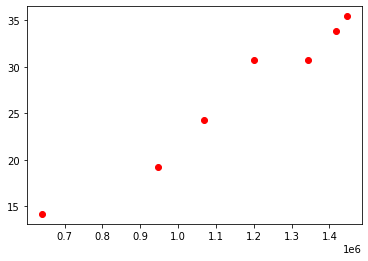

In [26]:
plt.plot([len(genome[0].seq.upper()), len(genome[1].seq.upper()), len(genome[2].seq.upper()),len(genome[3].seq.upper()), len(genome[4].seq.upper()), len(genome[5].seq.upper()), len(genome[6].seq.upper())], [t0-start0,t1-t0, t2-t1, t3-t2,t4-t3,t5-t4, end-t5], 'ro')
plt.show()

On observe des linéarités discontinues: la complexité semble linéaire entre le 2eme et 4eme chromosome, ainsi qu'entre le 5eme et le 7eme.

Mesurons le temps que prend chaque sous fonction de notre algorithme DC3 grâce à la bibliothèque cProfile.

In [27]:
cProfile.run("almost_dc3_with_p12(asciiDC3(genome[0].seq.upper()))", "dc3_stats")
p = pstats.Stats("dc3_stats")
p.sort_stats("cumulative").print_stats()

Fri Nov 10 19:54:06 2023    dc3_stats

         21257127 function calls (21257121 primitive calls) in 20.041 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   20.041   20.041 {built-in method builtins.exec}
        1    0.314    0.314   20.041   20.041 <string>:1(<module>)
      7/1    0.722    0.103   19.537   19.537 /tmp/ipykernel_25800/3977718216.py:1(almost_dc3_with_p12)
       14    0.095    0.007    5.132    0.367 /tmp/ipykernel_25800/2430097404.py:1(sort_with_p12)
       35    5.037    0.144    5.037    0.144 /tmp/ipykernel_25800/2430097404.py:29(counting_sort_by_digit_with_p12)
        7    3.191    0.456    3.285    0.469 /tmp/ipykernel_25800/3017114688.py:1(position0_R0_p0)
        7    3.044    0.435    3.114    0.445 /tmp/ipykernel_25800/762813728.py:1(radix_with_p12)
        7    2.396    0.342    2.815    0.402 /tmp/ipykernel_25800/3105641319.py:1(merge_with_p12)
        7    1.04

On constate que les fonctions les plus consommatrices en temps, sont les fonctions de tri, et le fonctions initiales de séparation des positions.

## 3/ Transformée de Burrow-Wheeler

In [28]:
def BWT_suffix_table(T,end_of_string=False):
    """
    Compute the BWT by calcultating the suffix_table of parameter 'T'
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    if end_of_string==False:
        T += '!'
    suffix_array=almost_dc3_with_p12(asciiDC3(T)) 
    bwt = ""
    for i in suffix_array:
        bwt += T[i-1]
    return(bwt)

def BWT(T, suffix_table,end_of_string=False):
    """
    Compute the BWT without calculating the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
        suffix_table (list of int): suffix table of parameter 'T'
    
    Return:
        bwt (str): BWT
    """
    if end_of_string==False:
        T += '!'
    bwt = ""
    for i in suffix_table:
        bwt += T[i-1]
    return(bwt)

# ATTENTION !!!! dans BWT, tu dois enlever end_of_string et toujours mettre des séquences avec un ! à la fin

##### Complexité : 
BWT_suffix_table utilise almost_dc3_with_p12 (qui a une complexité de $0(n)$, n étant la taille de 'T') et une boucle for qui parcourt suffix array (ce qui donne une compléxité de $0(m)$, m étant la taille de 'suffix_array'). Elle ajoute un élément à la fin de notre séquence d'ADN, qui sera donc de taille n+1.
Cela revient donc à une complexité de $0(n+1+m)$. Comme 'suffix_array' est la table de suffixe de T, elle est donc aussi de taille n. On a donc une complexité de $0(2n+1))$

BWT parcourt seulement 'suffix_table', elle a donc une complexité de $0(n)$, avec n la taille de la séquence T donnée en paramètre.

### Cherchons la transformée de Burrow-Wheeler d'un string simple

In [29]:
test_2='ATGCTAGCTGCCCTGATCTCTCTGA!'
suffix_array_2_with_p12=almost_dc3_with_p12(asciiDC3(test_2)) 

Visualisons la suffix table ainsi que la BWT de la séquence "test_2"

In [30]:
def print_suffix_table(sequence, sf, visualize_bwt=False):
    '''
    Allows visualisation of the suffix_table (parameter sf) of the given sequence (parameter sequence).
    If visualize_bwt is set to True, every line of the suffix_table starts with the corresponding
    letter of the BWT of parameter "sequence".
    
    Args:
        sequence(list of string) : Letter sequence from which we calculated the bwt and suffix table
        sf (list of int): positions in "sequence" of the first letter of every line of the suffix table
        visualize_bwt (bool): allows vizualisation of the BWT if set to "True"
    
    Return:
        None
    '''
    for i in range(len(sf)):
        if visualize_bwt:
            print(str(sequence[sf[i]-1])+"-"+str(sequence[sf[i]:]))
        else:
            print(str(sequence[sf[i]:]))
    return

##### Complexité : 
print_suffix_table parcourt 'sf', elle a donc une complexité de $0(n)$, n étant la taille de la sequence donnée en paramètre. 

In [31]:
# On visualise à la fois la suffix table, et en première position à gauche, la BWT
print_suffix_table(test_2,suffix_array_2_with_p12, visualize_bwt=True)

A-!
G-A!
T-AGCTGCCCTGATCTCTCTGA!
G-ATCTCTCTGA!
!-ATGCTAGCTGCCCTGATCTCTCTGA!
G-CCCTGATCTCTCTGA!
C-CCTGATCTCTCTGA!
G-CTAGCTGCCCTGATCTCTCTGA!
T-CTCTCTGA!
T-CTCTGA!
T-CTGA!
C-CTGATCTCTCTGA!
G-CTGCCCTGATCTCTCTGA!
T-GA!
T-GATCTCTCTGA!
T-GCCCTGATCTCTCTGA!
T-GCTAGCTGCCCTGATCTCTCTGA!
A-GCTGCCCTGATCTCTCTGA!
C-TAGCTGCCCTGATCTCTCTGA!
A-TCTCTCTGA!
C-TCTCTGA!
C-TCTGA!
C-TGA!
C-TGATCTCTCTGA!
C-TGCCCTGATCTCTCTGA!
A-TGCTAGCTGCCCTGATCTCTCTGA!


### Appliquons la transformée de Burrow-Wheeler à notre génome de référence

In [32]:
# Comme nous avons calculé les tables de suffixe précédemment, nous les incluons comme paramètre dans 
# notre calcul de BWT
start=time.time()
bwt_T=BWT(genome[0].seq.upper(),suffix_array_0)
end=time.time()
print("Calculer la transformée de Burrow-Wheeler de notre chromosome 1 prend "+str(end-start)+" secondes.")

Calculer la transformée de Burrow-Wheeler de notre chromosome 1 prend 0.46837425231933594 secondes.


Mesurons le temps que chaque sous fonction de la fonction "BWT_suffix_table" prend:

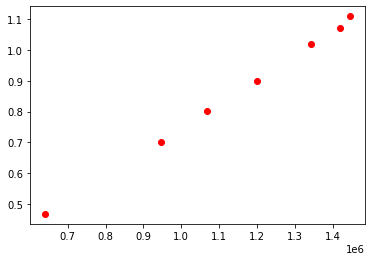

In [33]:
start=time.time()
bwt_T=BWT(genome[0].seq.upper(),suffix_array_0)
t0=time.time()
bwt_T=BWT(genome[1].seq.upper(),suffix_array_1)
t1=time.time()
bwt_T=BWT(genome[2].seq.upper(),suffix_array_2)
t2=time.time()
bwt_T=BWT(genome[3].seq.upper(),suffix_array_3)
t3=time.time()
bwt_T=BWT(genome[4].seq.upper(),suffix_array_4)
t4=time.time()
bwt_T=BWT(genome[5].seq.upper(),suffix_array_5)
t5=time.time()
bwt_T=BWT(genome[6].seq.upper(),suffix_array_6)
end=time.time()
plt.plot([len(genome[0].seq.upper()), len(genome[1].seq.upper()), len(genome[2].seq.upper()),len(genome[3].seq.upper()), len(genome[4].seq.upper()), len(genome[5].seq.upper()), len(genome[6].seq.upper())], [t0-start,t1-t0, t2-t1, t3-t2,t4-t3,t5-t4, end-t5], 'ro')
plt.show()

On observe bien une fonction de complexité temporelle linéaire

## 4/ Cherchons un pattern dans une séquence grâce à la transformée de Burrow-Wheeler

In [34]:
def new_suffix_table_positions_faster(BWT,pattern_letter, position_in_BWT, occurence_index, counts):
    '''
    Takes a list (parameter "position_in_BWT") of positions of letters in the BWT, 
    checks if those letters are equal to "pattern_letter", 
    and returns the positions in the BWT 
    of the letters that came right before those in "position_in_BWT" thats passed the check.
    
    Args:
        BWT (list of string): Burrows-Wheeler transform of a sequence
        pattern_letter (string): letter we want the elements of "position_in_BWT" to be equal to
        position_in_BWT (list of int): list of positions of elements of the BWT to be studied
        occurence_index (list of int): output of the function "occurence_indexer"
        counts (dict): keys are each distinct letter of BWT, 
                       elements are how many times each letter appears
    
    Return:
        output (list of int): new positions of elements of the BWT we want to study
    '''
    # Counter({'T': 3, 'A': 2, 'B': 2, 'C': 2, '!': 1})
    output=[]
    letter_and_occurence=[]
    for i in range(len(position_in_BWT)):
        if BWT[position_in_BWT[i]]==pattern_letter:
            letter_and_occurence=[BWT[position_in_BWT[i]],occurence_index[position_in_BWT[i]]]
            letter=letter_and_occurence[0]
            occurence=letter_and_occurence[1]
            new_position_to_evaluate=occurence + sum([counts[char] for char in counts if char < letter])
            output.append(new_position_to_evaluate)
    return output

def initialize_suffix_table_positions(counts, pattern_letter):
    '''
    Finds the all the positions in the suffix table, of the letter "pattern_letter"
    
    Args:
        counts (dict): keys are each distinct letter of BWT, 
                       elements are how many times each letter appears
        pattern_letter (string): letter we are searching positions for
    
    Return:
        (list of int): all the positions occupied by the letter "pattern_letter"
                       in the suffix table
    '''
    start=sum([counts[char] for char in counts if char < pattern_letter])
    end=start+counts[pattern_letter]
    return [i for i in range(start, end)]


##### Complexité  "new_suffix_table_positions_faster": 
La fonction "new_suffix_table_positions_faster" parcourt le paramètre 'position_in_BWT' et dans la compréhension de liste, elle parcourt le paramètre 'counts'. Dans le cas où la séquence est un chromosome, 'counts' a une taille de 5. Elle a donc une complexité de $0(n+5)$ avec n la taille de 'position_in_BWT'. 

##### Complexité  de "initialize_suffix_table_positions": 
La fonction parcourt deux fois le paramètre "counts" (de taille 5 dans le cas où la séquence est un chromosome), somme chaque élément de cette liste (liste qui est donc de taille 4 dans le pire des cas), et termine en parcourant la différence entre les variables "start" et "end" . C'est de la taille de la somme de tous les éléments de "counts".

Dans le cas où on travaille avec un chromosome de notre génome, elle est donc de complexité $0(n)$, avec n=taille du chromosome.

In [35]:
def occurrence_indexer(S):
    '''
    Returns a list of size len(S), from which each element i is the number of time S[i]
    has appeared in the sub-sequence S[:i-1].
    
    Args:
        S (list of string): sequence from which we want to count occurences
    
    Return:
        K (list of int): occurence of each element of S
    '''
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)

##### Complexité  de "occurrence_indexer": 
Elle est de complexité $0(n)$, avec n=taille de S

In [36]:
def find_patterns_in_sequence_faster(sf, BWT, pattern):
    '''
        Aligns "pattern" in the sequence (from which we calculated 
        the parameters "BWT" and the suffix table "sf"). Returns all the 
        starting positions of the alignments found.

    Args:
        sf (list of int): suffix table of the sequence we want to find pattern in
        BWT (list of string): BWT of the sequence we want to find pattern in
        pattern (string): pattern we want to find in the sequence
    
    Return:
        output (list of int): starting positions of all the alignments found
    '''
    output=[]
    occurence_index = occurrence_indexer(BWT)
    counts = Counter(BWT)
    index=len(pattern)-1
    pattern_letter=pattern[index]
    
    suffix_table_positions=initialize_suffix_table_positions(counts, pattern_letter)
    while index>0 and len(suffix_table_positions)>0:
        index-=1
        pattern_letter=pattern[index]
        suffix_table_positions=new_suffix_table_positions_faster(BWT,pattern_letter,suffix_table_positions,occurence_index,counts) 
        
    for i in range(len(suffix_table_positions)):
        output.append(sf[suffix_table_positions[i]])
        
    return output

def find_patterns_in_sequence_faster_with_dc3(sequence, pattern, sequence_has_end_character=False):
    '''
        Aligns "pattern" in the sequence by calculating it's suffix table
        and BWT. Returns all the 
        starting positions of the alignments found.

    Args:
        sequence (string): sequence where we want to align "pattern"
        sequence_has_end_character (bool): if "True", we add "!" at the end of "sequence"
        pattern (string): pattern we want to find in the sequence
    
    Return:
        output (list of int): starting positions of all the alignments found
    '''
    output=[]
    # adding an end character
    if sequence_has_end_character==False:
        sequence += '!'
    
    # computing the dc3
    sf=almost_dc3_with_p12(asciiDC3(sequence)) 
    
    #Computing the BWT
    BWT = ""
    for i in sf:
        BWT += sequence[i-1]
    
    output=[]
    occurence_index = occurrence_indexer(BWT)
    counts = Counter(BWT)
    index=len(pattern)-1
    pattern_letter=pattern[index]
    
    suffix_table_positions=initialize_suffix_table_positions(counts, pattern_letter)
    while index>0 and len(suffix_table_positions)>0:
        index-=1
        pattern_letter=pattern[index]
        suffix_table_positions=new_suffix_table_positions_faster(BWT,pattern_letter,suffix_table_positions,occurence_index,counts) 
        
    for i in range(len(suffix_table_positions)):
        output.append(sf[suffix_table_positions[i]])
        
    return output

##### Complexité  de "find_patterns_in_sequence_faster": 
 Les fonctions "Counter", "occurence_indexer", "initialize_suffix_table_positions", sont de complexité $0(n)$, avec n= taille de la séquence dans laquelle on cherche le pattern.
 
 La boucle while parcourt le paramètre "pattern" dont la taille est au pire des cas égale à n. Dans la boucle while, on trouve "new_suffix_table_positions_faster" de complexité $0(n)$.
 La boucle for parcourt toutes les positions d'alignement trouvées par la fonction, donc elle parcourt au pire n éléments.
 
 La fonction est donc de complexité $0(n²)$.
.

##### Complexité  de "find_patterns_in_sequence_faster_with_dc3": 
La fonction diffère de find_patterns_in_sequence_faster par le fait qu'elle calcule la suffix table et la BWT de la séquence dans laquelle on veut aligner le pattern.

Ces deux fonctions sont linéaires, la complexité reste $0(n²)$.

### Cherchons un pattern simple dans un texte simple

In [37]:
texte_simple='ABCDEFGHIJKLMNOPABCDEFGHIJKLMNOP!'
pattern_simple='GHIJK'

#Calculons la suffix table du texte 
sf=almost_dc3_with_p12(asciiDC3(texte_simple))

# Alignons le pattern dans le texte
positions_of_pattern=find_patterns_in_sequence_faster_with_dc3(texte_simple, pattern_simple, sequence_has_end_character=True)
print("Le pattern est à la positions "+str(positions_of_pattern)+" du texte simple")

# Montrons que l'alignement est juste
for p in positions_of_pattern:
    print("A la position "+str(p)+" du texte simple, la séquence est "+str(texte_simple[p:p+6]))

Le pattern est à la positions [22, 6] du texte simple
A la position 22 du texte simple, la séquence est GHIJKL
A la position 6 du texte simple, la séquence est GHIJKL


## 5/  Importation des données expérimentales

In [ ]:
#Importation du fichier BAM
bam=pysam.AlignmentFile("/home/azarkua/Documents/2023-2024/omiques2/developement/omique2/single_Pfal_dat.bam", "rb")
#bam = pysam.AlignmentFile("/home/mvernier/Documents/2023-2024/omique2/projet/single_Pfal_dat.bam", "rb")

donnees_experimentales=[]
for alignment in bam:
    read_name = alignment.query_name
    reference_name = bam.getrname(alignment.reference_id)
    position = alignment.reference_start
    mapping_quality = alignment.mapping_quality
    
    donnees_experimentales.append(position)
    
bam.close()

## 6/ Créer et aligner les kmers de nos reads

In [38]:
def kmer(sequence, longueur):
    '''
        Creates kmers of size "longueur" from "sequence"

    Args:
        sequence (string): sequence we want to create kmers from
        longueur (int): size of kmers
    
    Return:
        kmer (list of string): list of all the kmers
    '''
    n = len(sequence)
    kmer=[]
    for i in range(n-longueur+1):
        kmer.append(sequence[i:i+longueur])
    return kmer
    

##### Complexité : 
kmer parcourt 'sequence'-longueur+1, elle a donc une complexité de $0(n)$ avec n=taille de 'sequence'-longueur+1

In [39]:
def position_with_suffix_table(liste_kmer, genome):
    output=[]
    for i in range(len(liste_kmer)):
        output.append(find_patterns_in_sequence_with_dc3(genom, liste_kmer[i],sequence_has_end_character=True))
    return output

def position(liste_kmer, bwt, suffix_table):
    output=[]
    for i in range(len(liste_kmer)):
        output.append(find_patterns_in_sequence_faster(suffix_table, bwt, liste_kmer[i]))
    return output

##### Complexité : 
position_with_suffix_table parcourt 'liste_kmer' et utilise 'find_patterns_in_sequence_with_dc3' (qui a une complexité de ?), elle a donc une complexité de $0()$

position parcourt 'liste_kmer' et utilise 'find_patterns_in_sequence_with_dc3' (qui a une complexité de ?), elle a donc une complexité de $0()$

position_sorted parcourt 'liste_kmer' et utilise 'find_patterns_in_sequence_with_dc3' (qui a une complexité de ?) et 'sorted' (qui a une complexité $0(nlogn)$, n étant la taille de la séquence fournie), elle a donc une complexité de $0()$

In [40]:
def complementaire_inverse(sequence):
    ci = []
    for i in range(len(sequence) - 1, -1, -1):
        if sequence[i] == 'A':
            ci.append('T')
        elif sequence[i] == 'T':
            ci.append('A')
        elif sequence[i] == 'C':
            ci.append('G')
        elif sequence[i] == 'G':
            ci.append('C')
    return ''.join(ci)

##### Complexité : 
complementaire_inverse parcourt 'sequence' et utilise 'join' qui a une complexité linéaire,  elle a donc une complexité $0(n²)$, n étant la taille de 'sequence'

In [41]:
def assembler_des_kmers(numero_du_kmer, position_ds_genome,longueur, liste_position_kmers):
    compteur_de_kmer=1 #compte le nb de kmers qu'on arrive à aligner
    last_position=0
    i=numero_du_kmer+1
    difference=1
    
    while i<len(liste_position_kmers):
        j=0
        previous_compteur=compteur_de_kmer
        k=0
        while j<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:
            # on ne quitte pas la boucle while tant qu'on a pas réussi
            # à aligner un kmer, où qu'on a pas parcouru la liste des positions prises par le kmer
            if position_ds_genome+difference==liste_position_kmers[i][j]:
                compteur_de_kmer+=1
                last_position=liste_position_kmers[i][j]
            j+=1
            
        if compteur_de_kmer==previous_compteur:
            # si on a pas réussi à aligner ce kmer
            i+=longueur
            # on continue l'alignement à partir du kmer 10 positions plus loin
            difference+=longueur
            if  i>= len(liste_position_kmers):
                # on vérifie que 10 positions plus loin on aie pas atteint la fin de notre read
                return [[position_ds_genome,last_position+longueur],compteur_de_kmer]
            else:
                
                #on teste si l'absence d'alignement est du à un mutation
                k=0

                while k<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:
                    if position_ds_genome+difference==liste_position_kmers[i][k]:
                        compteur_de_kmer+=1
                        last_position=liste_position_kmers[i][k]
                    k+=1



                if compteur_de_kmer==previous_compteur:
                    ###cas d'une addition
                    difference-=1
                    l=0
                    while l<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:

                        if position_ds_genome+difference==liste_position_kmers[i][l]:
                            compteur_de_kmer+=1
                            last_position=liste_position_kmers[i][l]
                        l+=1

                    if compteur_de_kmer==previous_compteur:
                        ###cas d'une déletions
                        difference+=1
                        i-=1
                        m=0
                        while m<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:

                            if position_ds_genome+difference==liste_position_kmers[i][m]:
                                compteur_de_kmer+=1
                                last_position=liste_position_kmers[i][m]
                            m+=1

                        if compteur_de_kmer==previous_compteur:
                            ### cas où l'alignement est terminé
                            return [[position_ds_genome,last_position+longueur],compteur_de_kmer]

        i+=1
        difference+=1   
        
    return [[position_ds_genome,last_position+longueur],compteur_de_kmer]

In [42]:
def alignement_maximum_de_kmer(liste_position_kmers, longueur):
    output=[[0,0],0]
    maximum=0
    for i in range(longueur+1):
        current_kmer=liste_position_kmers[i]
        for p in current_kmer:
            alignement=assembler_des_kmers(i, p, longueur, liste_position_kmers)
            if maximum<alignement[1]:
                output=alignement
                maximum=alignement[1]
    return output

##### Complexité : 
alignement_maximum_de_kmer parcourt 'longueur'+1 et 'current_kmer' et utilise 'assembler_des_kmers'(qui a une complexité $0()$, elle a donc une complexité $0()$

In [43]:
def align_read(chromosome, reads_list, longueur_kmer):
    sf=almost_dc3_with_p12(asciiDC3(chromosome))
    bwt=BWT(chromosome, sf)
    output=[]
    
    for i in range(len(reads_list)): # on parcourt la liste de toutes les positions des kmers
        liste_de_kmer=kmer(reads_list[i].seq.upper(), longueur_kmer)
        position=[]
        for j in range(len(liste_de_kmer)):
            # on démarre notre recherche d'alignement à partir des 10 premiers
            # kmers, pour anticiper le cas où une SNP se trouve au début du read
            position.append(find_patterns_in_sequence_faster(sf,bwt, liste_de_kmer[j]))
        
        alignment=alignement_maximum_de_kmer(position, longueur_kmer)
        
        
        if (alignment[0][1]-alignment[0][0])<30:
            # si l'alignement est trop mauvais
            # on cherche à aligner le complémentaire inverse
            liste_de_kmer=kmer(complementaire_inverse(reads_list[i].seq.upper()), longueur_kmer)
            position=[]
            for j in range(len(liste_de_kmer)):
                position.append(find_patterns_in_sequence_faster(sf,bwt, liste_de_kmer[j]))
                
            alignment=alignement_maximum_de_kmer(position, longueur_kmer)
            
        # on crée un immense liste avec tous les alignements trouvés        
        output.append({"read":i, "alignement":alignment})
    return output
        

##### Complexité :
align_read parcourt 'reads_list', 'liste_kmer' utilise almost_dc3_with_p12, asciiDC3, BWT, kmer, find_patterns_in_sequence_faster, alignement_maximum_de_kmer et dans le pire des cas (si on doit chercher dans le complémentaire inverse) utilise aussi complementaire_inverse, find_patterns_in_sequence_faster, alignement_maximum_de_kmer et reparcourt liste_de_kmer. 

### Testons notre algorithme avec un exemple simple 

In [44]:
read="ABCDEFGHIJKLMNOPQRSTUV"
genom="ABCDEFGHIJKLMNOPQRSTUVWWWWWWWWWABCDEFGHWWWWWWWWWWQRSTUV!"
liste_kmer=kmer(read, 5)
positions_alphabet=position_with_suffix_table(liste_kmer, genom)

NameError: name 'find_patterns_in_sequence_with_dc3' is not defined

Visualisons les positions occupées par les kmers de "read"

In [ ]:
print(positions_alphabet)

Quel alignement trouve la fonction "assembler_des_kmers" lorsque la première position occupée par le premier kmer lui est fournie ?

In [ ]:
assembler_des_kmers(0, positions_alphabet[0][0],5,positions_alphabet)

Quel est l'alignement de kmer le plus long que trouve la fonction "alignement_maximum_de_kmer" ?

In [ ]:
alignement_maximum_de_kmer(positions_alphabet, 5)

# ZONE DE TEST

In [ ]:
sf=almost_dc3_with_p12(asciiDC3(genome[0].seq.upper()+"!")) # suffix table du 1er chromosome
bwt=BWT(genome[0].seq.upper()+"!", sf, True)

In [ ]:
current_read=reads[1].seq.upper()[:90]
current_genome=genome[0].seq.upper()
starting_position=143900
print("read")
print(current_read)
print("genome")
print(current_genome[starting_position:starting_position+len(current_read)])

In [ ]:
liste_kmer=kmer(current_read, 10)
print(liste_kmer)

In [ ]:
positions=position_sorted(liste_kmer, bwt,sf)
print(positions[:4])
print(positions[len(positions)-4:])

In [ ]:
assembler_dernier_kmer(positions, 3)


In [ ]:
aligner_un_read_faster(current_read,10, positions, 3, 5)

In [ ]:
def assembler_premier_kmer(positions, nb_de_kmer_a_aligner):
    """
    Les positions doivent être triées pour que cette fonction marche
    """

    positions_initiales=positions[0]

    for i in range(1,nb_de_kmer_a_aligner):
        current_kmer_positions=positions[i]
        index_1=0
        index_2=0
        new_initial_positions=copy.deepcopy(positions_initiales)
        
        while index_1<len(positions_initiales) and index_2<len(current_kmer_positions):

            while positions_initiales[index_1]+i>current_kmer_positions[index_2] and index_2+1<len(current_kmer_positions):
                index_2+=1
            if positions_initiales[index_1]+i!=current_kmer_positions[index_2]:
                new_initial_positions.remove(positions_initiales[index_1])
                index_1+=1
            else:

                index_1+=1
                
        positions_initiales=new_initial_positions
                     
    return positions_initiales

##### Complexité: 
assembler_premier_kmer fait une boucle for de la taille 'nb_de_kmer_a_aligner' 

In [ ]:
def assembler_dernier_kmer(positions, nb_de_kmer_a_aligner):
    """
    Les positions doivent être triées pour que cette fonction marche
    """

    positions_finales=positions[-1]
    for i in range(1,nb_de_kmer_a_aligner):
        current_kmer_positions=positions[-1-i]
        index_1=len(positions_finales)-1
        index_2=len(current_kmer_positions)-1
        new_final_positions=copy.deepcopy(positions_finales)
        
        while index_1>=0 and index_2>=0:

            while positions_finales[index_1]-i<current_kmer_positions[index_2] and index_2>=0:
                index_2-=1
            if positions_finales[index_1]-i!=current_kmer_positions[index_2]:
                new_final_positions.remove(positions_finales[index_1])
                index_1-=1
            else:

                index_1-=1
                
        positions_finales=new_final_positions
                     
    return positions_finales

In [ ]:
def assembler_dernier_kmer_debugg(positions, nb_de_kmer_a_aligner):
    """
    Les positions doivent être triées pour que cette fonction marche
    """

    positions_finales=positions[-1]
    print("positions finales")
    print(positions_finales)
    print("\n")
    for i in range(1,nb_de_kmer_a_aligner):
        current_kmer_positions=positions[-1-i]
        print("kmer dont on étudie les positions")
        print(current_kmer_positions)
        print("\n")
        index_1=len(positions_finales)-1
        index_2=len(current_kmer_positions)-1
        new_final_positions=copy.deepcopy(positions_finales)
        
        while index_1>=0 and index_2>=0:
            print("index_1")
            print(index_1)
            print("index_2")
            print(index_2)
            print("\n")
            print("positions_finales[index_1]-i")
            print(positions_finales[index_1]-i)
            print("current_kmer_positions[index_2]")
            print(current_kmer_positions[index_2])

            while positions_finales[index_1]-i<current_kmer_positions[index_2] and index_2>=0:
                print(str(positions_finales[index_1]-i)+"<"+str(current_kmer_positions[index_2]))
                index_2-=1
            if positions_finales[index_1]-i!=current_kmer_positions[index_2]:
                new_final_positions.remove(positions_finales[index_1])
                index_1-=1
            else:

                index_1-=1
                
        positions_finales=new_final_positions
                     
    return positions_finales

In [ ]:
def assembler_n_kmers_alignes_debugg(positions, nb_de_kmer_a_aligner, premier_kmer=True):
    """
    Les positions doivent être triées pour que cette fonction marche
    """

    if premier_kmer:
        positions_initiales=positions[0]
    else:
        positions_initiales=positions[-1]
    print("positions initiales")
    print(positions_initiales)
    print("\n")
    for i in range(1,nb_de_kmer_a_aligner):
        if premier_kmer:
            current_kmer_positions=positions[i]
        else:
            i=i*(-1)
            current_kmer_positions=positions[-1+i]
        print("kmer dont on étudie les positions")
        print(current_kmer_positions)
        print("\n")
        index_1=0
        index_2=0
        new_initial_positions=copy.deepcopy(positions_initiales)
        
        while index_1<len(positions_initiales) and index_2<len(current_kmer_positions):
            print("index_1")
            print(index_1)
            print("index_2")
            print(index_2)
            print("\n")
            print("(math.copysign(1,i)*positions_initiales[index_1]+i)")
            print(math.copysign(1,i)*(positions_initiales[index_1]+i))
            print("(math.copysign(1,i)*current_kmer_positions[index_2])")
            print((math.copysign(1,i)*current_kmer_positions[index_2]))

            print(str(math.copysign(1,i)*(positions_initiales[index_1]+i))+">"+str((math.copysign(1,i)*current_kmer_positions[index_2])))
            print((math.copysign(1,i)*positions_initiales[index_1]+i)>(math.copysign(1,i)*current_kmer_positions[index_2]))
            print("\n")
            while math.copysign(1,i)*(positions_initiales[index_1]+i)>(math.copysign(1,i)*current_kmer_positions[index_2]) and index_2+1<len(current_kmer_positions):
                index_2+=1
            if positions_initiales[index_1]+i!=current_kmer_positions[index_2]:
                new_initial_positions.remove(positions_initiales[index_1])
                index_1+=1
            else:
                print("elgalité")
                index_1+=1
                
        print("new_initial_positions")
        print(new_initial_positions)
        positions_initiales=new_initial_positions
                     
    return positions_initiales

In [ ]:
def aligner_un_read_faster(read, taille_kmer, positions, nb_de_kmer_a_aligner, erreurs):
    positions_initiales=assembler_premier_kmer(positions, nb_de_kmer_a_aligner)
    positions_finales=assembler_dernier_kmer(positions, nb_de_kmer_a_aligner)
    ### les positions doivent être dans l'ordre normalement

    final_positions=[]
    for i in range(len(positions_initiales)):
        one_align=0
        for j in range(len(positions_finales)):
            if positions_initiales[i]+len(read)-taille_kmer-erreurs<=positions_finales[j]<=positions_initiales[i]+len(read)-taille_kmer+erreurs:
                one_align+=1
        if one_align>0:
            final_positions.append(positions_initiales[i])
            
    return final_positions

In [ ]:
def aligner_un_read_faster_debugg(read, taille_kmer, positions, nb_de_kmer_a_aligner, erreurs):
    positions_initiales=assembler_premier_kmer(positions, nb_de_kmer_a_aligner)
    positions_finales=assembler_dernier_kmer(positions, nb_de_kmer_a_aligner)
    print("positions_initiales")
    print(positions_initiales)
    print("\n")
    print("positions_finales")
    print(positions_finales)
    print("\n")
    ### les positions doivent être dans l'ordre normalement

    final_positions=[]
    for i in range(len(positions_initiales)):
        one_align=0
        for j in range(len(positions_finales)):
            print("positions_initiales[i]")
            print(positions_initiales[i])
            print("positions_finales[j]")
            print(positions_finales[j])
            print("len(read)")
            print(len(read))
            if positions_initiales[i]+len(read)-taille_kmer-erreurs<=positions_finales[j]<=positions_initiales[i]+len(read)-taille_kmer+erreurs:
                one_align+=1
        if one_align>0:
            final_positions.append(positions_initiales[i])
            
    return final_positions

In [ ]:
print(positions_alphabet)

In [ ]:
assembler_premier_kmer(positions_alphabet, 4)

In [ ]:
assembler_dernier_kmer(positions_alphabet, 4)

In [ ]:
aligner_un_read_faster("ABCDEFGHIJKLMNOPQRSTUV",5, positions_alphabet, 4, 2)

In [ ]:
def assembler_des_kmers_debugg(numero_du_kmer, position_ds_genome,longueur, liste_position_kmers):
    compteur_de_kmer=1 #compte le nb de kmers qu'on arrive à aligner
    last_position=0
    i=numero_du_kmer+1
    difference=1
    
    while i<len(liste_position_kmers):
        j=0
        previous_compteur=compteur_de_kmer
        k=0
        while j<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:
            # on ne quitte pas la boucle while tant qu'on a pas réussi
            # à aligner un kmer, où qu'on a pas parcouru la liste des positions prises par le kmer
            if position_ds_genome+difference==liste_position_kmers[i][j]:
                compteur_de_kmer+=1
                last_position=liste_position_kmers[i][j]
            j+=1
            
        if compteur_de_kmer==previous_compteur:
            # si on a pas réussi à aligner ce kmer
            i+=longueur
            # on continue l'alignement à partir du kmer 10 positions plus loin
            difference+=longueur
            if  i>= len(liste_position_kmers):
                # on vérifie que 10 positions plus loin on aie pas atteint la fin de notre read
                return [[position_ds_genome,last_position+longueur],compteur_de_kmer]
            else:
                
                #on teste si l'absence d'alignement est du à un mutation
                k=0

                while k<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:
                    if position_ds_genome+difference==liste_position_kmers[i][k]:
                        compteur_de_kmer+=1
                        last_position=liste_position_kmers[i][k]
                    k+=1



                if compteur_de_kmer==previous_compteur:
                    ###cas d'une addition
                    difference-=1
                    l=0
                    while l<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:

                        if position_ds_genome+difference==liste_position_kmers[i][l]:
                            compteur_de_kmer+=1
                            last_position=liste_position_kmers[i][l]
                        l+=1

                    if compteur_de_kmer==previous_compteur:
                        ###cas d'une déletions
                        difference+=1
                        i-=1
                        m=0
                        while m<len(liste_position_kmers[i]) and compteur_de_kmer==previous_compteur:

                            if position_ds_genome+difference==liste_position_kmers[i][m]:
                                compteur_de_kmer+=1
                                last_position=liste_position_kmers[i][m]
                            m+=1

                        if compteur_de_kmer==previous_compteur:
                            ### cas où l'alignement est terminé
                            return [[position_ds_genome,last_position+longueur],compteur_de_kmer]

        i+=1
        difference+=1   
        
    return [[position_ds_genome,last_position+longueur],compteur_de_kmer]

In [ ]:
find_patterns_in_sequence_with_dc3(current_genome, 'CATGATTTAC', sequence_has_end_character=False)

In [ ]:
find_patterns_in_sequence_faster(sf, bwt, liste_kmer[0])

In [ ]:
alignement_maximum_de_kmer(positions, 10)

In [ ]:
assembler_des_kmers(0, positions[0][0],10,positions)

# FIN ZONE DE TEST

##### Testons sur notre génome

In [ ]:
premier_chr=genome[0].seq.upper()+"!"
sf=almost_dc3_with_p12(asciiDC3(premier_chr)) # suffix table du 1er chromosome
bwt=BWT(premier_chr, sf, True)
liste_de_kmer=kmer(reads[2].seq.upper(), 10) # liste de kmers de taille 10 sur le 2e read
positions=position(liste_de_kmer, bwt,sf)

In [ ]:
alignement_maximum_de_kmer(positions, 10)

In [ ]:
start=time.time()
align=align_read(premier_chr,reads[:2], 10)
end=time.time()
print(align)
print(end-start)

In [ ]:
align=align_read(premier_chr,reads[5:10], 10)
print(align)

In [ ]:
print(align[0]["alignement"][0][0])

### Testons si nos reads ont des mutations 

In [ ]:
def check_for_mutation(index, read_decalage,genome_decalage, read,genome):
    return read[read_decalage+index+1]==genome[genome_decalage+index+1]


def check_for_deletion(index, read_decalage, genome_decalage, read,genome):
    return read[read_decalage+index]==genome[genome_decalage+index+1]

def check_for_addition(index, read_decalage, genome_decalage, read,genome):
    return read[read_decalage+index+1]==genome[genome_decalage+index]

def compare_read_and_genome(position_in_genome, read,genome):
    read_decalage=0
    genome_decalage=position_in_genome
    str_read=""
    str_genome=""
    i=0
    while i+read_decalage<len(read):
        if read[read_decalage+i]!=genome[genome_decalage+i]:
            if check_for_mutation(i, read_decalage,genome_decalage, read,genome):
                str_read+="*"+read[read_decalage+i]+"*"
                str_genome+="*"+genome[genome_decalage+i]+"*"
                i+=1
                
            elif check_for_deletion(i, read_decalage,genome_decalage, read,genome):
                str_read+="-"
                str_genome+=genome[genome_decalage+i]
                genome_decalage+=1
                i+=1
                
            elif check_for_addition(i, read_decalage, genome_decalage, read,genome):
                str_read+=read[read_decalage+i]
                str_genome+="+"+genome[genome_decalage+i]
                i+=1
                read_decalage+=1
                
            else:
                i+=1
                print("Nous observons plus d'une erreur d'alignement à la suite qui se suivent entre les positions "+str(genome_decalage+i-1)+" et "+str(genome_decalage+i))
        else:
            str_read+=read[read_decalage+i]
            str_genome+=genome[genome_decalage+i]
            i+=1
            
    print("read")
    print(str_read)
        
    print("genome")
    print(str_genome)
    return

#### Testons notre algorithme sur un exemple 

In [ ]:
current_read=reads[1].seq.upper()
current_genome=genome[0].seq.upper()
starting_position=143900

Les fonctions suivantes nous permettent de visualiser les zones de SNP

In [ ]:
compare_read_and_genome(starting_position,current_read,current_genome)

In [ ]:
cProfile.run("align_read(premier_chr,reads[5:10], 10)", "pattern_matching_stats")
p = pstats.Stats("pattern_matching_stats")
p.sort_stats("cumulative").print_stats()

### Comparaison des résultats théoriques avec les résultats expérimentaux

In [ ]:
error=0
for i in range(len(align)):
    if (tab[i+5]!=align[i]["alignement"][0][0]):
        error+=1
pourcentage_erreur=(error/len(align))*100
print("Le pourcentage d'erreur est "+str(pourcentage_erreur)+"%")

### Analyse de la qualité des séquences 


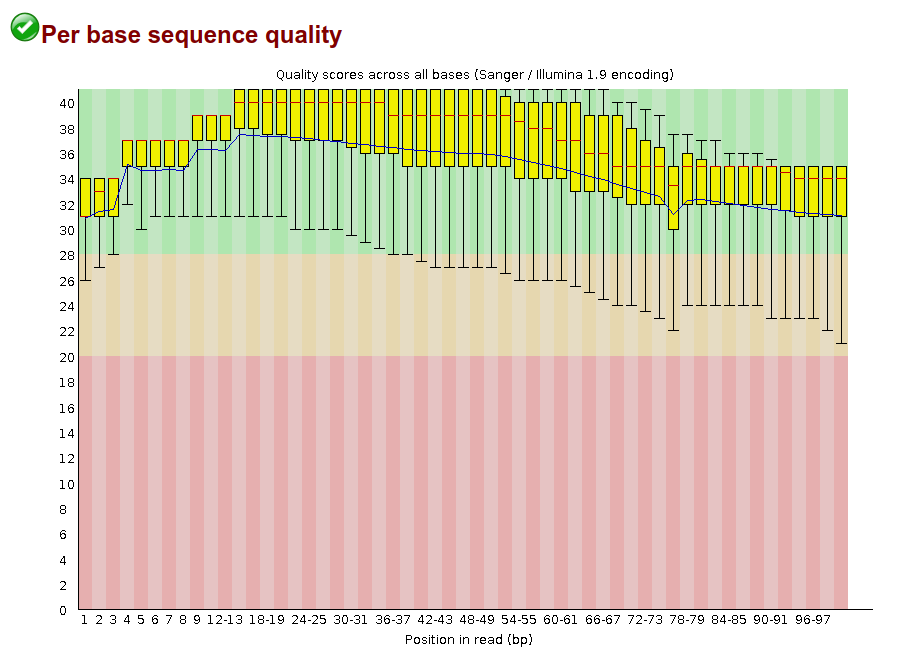

Nous pouvons voir grâce à FastQC que la qualité de nos séquence est plutôt bonne, malgré une légère diminution de la qualité en début et fin des reads.